# Import Packages

In [1]:
import pandas as pd
import pingouin as pg
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel


# Data cleaning
This part includes the deletion of columns such as metadata that is not needed

In [2]:
data = pd.read_csv('dataset.csv', sep='\\t', engine='python', encoding='utf-16')
data = data.fillna(-1) 

# Display the first few rows of the dataframe
data.head()

,"""CASE""","""SERIAL""","""REF""","""QUESTNNR""","""MODE""","""STARTED""","""DE01_01""","""DE03""","""DE04""","""DE05""",...,"""MAILSENT""","""LASTDATA""","""STATUS""","""FINISHED""","""Q_VIEWER""","""LASTPAGE""","""MAXPAGE""","""MISSING""","""MISSREL""","""TIME_RSI"""
0,50,-1.0,-1.0,"""bachelor_thesis""","""interview""",2025-07-17 08:10:34,"""19""",2,1,1,...,-1.0,2025-07-17 08:12:54,-1.0,1,0,8,8,0,0,"1,92"
1,54,-1.0,-1.0,"""bachelor_thesis""","""interview""",2025-07-17 08:15:22,"""24""",2,1,2,...,-1.0,2025-07-17 08:23:52,-1.0,1,0,8,8,0,0,"1,08"
2,59,-1.0,-1.0,"""bachelor_thesis""","""interview""",2025-07-17 08:45:05,"""25""",2,2,1,...,-1.0,2025-07-17 09:08:24,-1.0,1,0,8,8,0,0,"1,1"
3,60,-1.0,-1.0,"""bachelor_thesis""","""interview""",2025-07-17 08:49:57,"""25""",5,1,2,...,-1.0,2025-07-17 09:11:53,-1.0,1,0,8,8,0,0,"0,56"
4,61,-1.0,-1.0,"""bachelor_thesis""","""interview""",2025-07-17 08:55:37,"""21""",2,1,1,...,-1.0,2025-07-17 08:57:48,-1.0,1,0,8,8,0,0,"2,06"


In [3]:
column_names = data.columns
print(column_names)

Index(['"CASE"', '"SERIAL"', '"REF"', '"QUESTNNR"', '"MODE"', '"STARTED"',
       '"DE01_01"', '"DE03"', '"DE04"', '"DE05"', '"DE06"', '"DE07"',
       '"NE02_01"', '"NE02_02"', '"NE02_03"', '"NE02_04"', '"NE02_05"',
       '"PA01_01"', '"PA01_02"', '"PA01_03"', '"PA01_04"', '"PA01_05"',
       '"PA01_06"', '"PA02_01"', '"PA02_02"', '"PA02_03"', '"PA02_04"',
       '"PA02_05"', '"PA02_06"', '"PS05_01"', '"PS05_02"', '"PS05_03"',
       '"PS05_04"', '"PS05_05"', '"PS05_06"', '"PS05_07"', '"PS06_01"',
       '"PS06_02"', '"PS06_03"', '"PS06_04"', '"PS06_05"', '"PS06_06"',
       '"PS06_07"', '"SA02_01"', '"SI02_01"', '"SI02_02"', '"SI02_03"',
       '"SI02_04"', '"SI02_05"', '"SI02_06"', '"TIME001"', '"TIME002"',
       '"TIME003"', '"TIME004"', '"TIME005"', '"TIME006"', '"TIME007"',
       '"TIME008"', '"TIME_SUM"', '"MAILSENT"', '"LASTDATA"', '"STATUS"',
       '"FINISHED"', '"Q_VIEWER"', '"LASTPAGE"', '"MAXPAGE"', '"MISSING"',
       '"MISSREL"', '"TIME_RSI"'],
      dtype='object')


In [4]:
# List of metadata to be deleted
columns_to_delete = [
    'CASE', 'SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 
    'TIME001', 'TIME002', 'TIME003', 'TIME004', 'TIME006', 'TIME007', 
    'TIME008', 'TIME_SUM', 'MAILSENT', 'LASTDATA', 'STATUS', 'Q_VIEWER', 
    'LASTPAGE', 'MAXPAGE', 'MISSING', 'MISSREL', 'TIME_RSI'
]

# The column names in the dataframe are quoted, so we add quotes to the names
quoted_columns_to_delete = [f'"{col}"' for col in columns_to_delete]

# Create data_cleaned by dropping metadata columns from the original dataframe
data_cleaned = data.drop(columns=quoted_columns_to_delete, errors='ignore')

# Create data_finished_players for participants who finished the survey
status_column = '"FINISHED"'
finished_indices = data[data[status_column] == 1].index
data_finished_players = data_cleaned.loc[finished_indices].copy()



## Invert the data from inverted questions
Before starting the analysis, inverted questions from the Likert scale need to be reverted

In [5]:
# --- Invert Reversed Scored Items ---

# Columns to invert
columns_to_invert = ['"NE02_03"', '"PA01_05"', '"PA02_05"', '"PS05_04"', '"PS06_04"']

# Convert columns to numeric before inverting
for col in columns_to_invert:
    # Check if column exists before trying to invert
    if col in data_finished_players.columns:
        data_finished_players[col] = pd.to_numeric(data_finished_players[col], errors='coerce')
        # Invert the values (1=7, 2=6, ..., 7=1)
        # The formula for this is 8 - value
        data_finished_players[col] = 8 - data_finished_players[col]

print("Inverted the following columns:")
print([c.strip('"') for c in columns_to_invert])

Inverted the following columns:
['NE02_03', 'PA01_05', 'PA02_05', 'PS05_04', 'PS06_04']


# Data analysis

## Data analysis (demographics)
This part is about the data analysis of the participants' demographics

In [6]:
# Total number of participants
total_participants = len(data_cleaned)

# Participants who finished the game
num_finished_players = len(data_finished_players)

percentage_finished = (num_finished_players / total_participants) * 100 if total_participants > 0 else 0

# Average time spent 
time_column = '"TIME005"'
time_values = pd.to_numeric(data_finished_players[time_column], errors='coerce')
average_time_seconds = time_values.mean()
average_time_minutes = average_time_seconds / 60

print(f"Total number of participants: {total_participants}")
print(f"Number of participants who finished the game: {num_finished_players}")
print(f"Percentage of players who finished the game: {percentage_finished:.2f}%")
print(f"Average game time: {average_time_minutes:.2f} minutes")


Total number of participants: 66
Number of participants who finished the game: 47
Percentage of players who finished the game: 71.21%
Average game time: 14.94 minutes


### Data analysis with finished participants (demographics)

This part is about the data analysis of those participants' demographics, who finished the survey. This dataset is used throughout the  upcoming analyses

In [7]:
# --- demographic analysis of the participants ---

# Age (DE01_01)
age_column = '"DE01_01"' 
# Get numerical values from the age column, stripping quotes and converting to numeric
age_values = pd.to_numeric(data_finished_players[age_column].str.strip('"'), errors='coerce')
average_age = age_values.mean()
print("--- Age ---")
print(age_values.describe())
print(f"The average age is: {average_age:.2f} years")

# Study major (DE03)
study_major_map = {
    1: "MINT", 2: "Economics", 3: "Social Sciences", 4: "Cultural Studies",
    5: "Law", 6: "Medicine", 7: "Teaching", 8: "Psychology",
    9: "Art", 10: "Media", 11: "Other"
}
study_column = '"DE03"'

study_counts = data_finished_players[study_column].astype(int).value_counts().rename(index=study_major_map)
total_study = study_counts.sum()
study_percentages = (study_counts / total_study * 100).round(2)
study_output = study_counts.astype(str) + " (" + study_percentages.astype(str) + "%)"
print("--- Study major ---")
print(study_output)
print("\n" + "="*30 + "\n")

# Gender (DE04)
gender_map = {1: "Male", 2: "Female", 3: "Diverse", 4: "Other"}
gender_column = '"DE04"'
gender_counts = data_finished_players[gender_column].astype(int).value_counts().rename(index=gender_map)
total_gender = gender_counts.sum()
gender_percentages = (gender_counts / total_gender * 100).round(2)
gender_output = gender_counts.astype(str) + " (" + gender_percentages.astype(str) + "%)"
print("--- Gender ---")
print(gender_output)
print("\n" + "="*30 + "\n")

# Highest Degree (DE05)
degree_map = {
    1: "high school diploma (Abitur)", 2: "Bachelor", 3: "Master", 4: "in training", 5: "Other"
}
degree_column = '"DE05"'
degree_counts = data_finished_players[degree_column].astype(int).value_counts().rename(index=degree_map)
total_degree = degree_counts.sum()
degree_percentages = (degree_counts / total_degree * 100).round(2)
degree_output = degree_counts.astype(str) + " (" + degree_percentages.astype(str) + "%)"
print("--- Highest Degree ---")
print(degree_output)
print("\n" + "="*30 + "\n")

# Current working situation (DE06)
work_map = {
    1: "Studying", 2: "Working student", 3: "Part-time", 4: "Full-time",
    5: "Minijob", 6: "Dual studies", 7: "Other"
}
work_column = '"DE06"'
work_counts = data_finished_players[work_column].astype(int).value_counts().rename(index=work_map)
total_work = work_counts.sum()
work_percentages = (work_counts / total_work * 100).round(2)
work_output = work_counts.astype(str) + " (" + work_percentages.astype(str) + "%)"
print("--- Current working situation ---")
print(work_output)
print("\n" + "="*30 + "\n")

# Semester (DE07)
semester_map = {1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7+"}
semester_column = '"DE07"'
semester_counts = data_finished_players[semester_column].astype(int).value_counts().rename(index=semester_map).sort_index()
total_semester = semester_counts.sum()
semester_percentages = (semester_counts / total_semester * 100).round(2)
semester_output = semester_counts.astype(str) + " (" + semester_percentages.astype(str) + "%)"
print("--- Semester ---")
print(semester_output)
print("\n" + "="*30 + "\n")

--- Age ---
count    47.000000
mean     23.638298
std       4.013161
min      19.000000
25%      21.000000
50%      23.000000
75%      25.000000
max      43.000000
Name: "DE01_01", dtype: float64
The average age is: 23.64 years
--- Study major ---
"DE03"
MINT                23 (48.94%)
Economics           15 (31.91%)
Cultural Studies      3 (6.38%)
Law                   2 (4.26%)
Medicine              2 (4.26%)
Teaching              1 (2.13%)
Social Sciences       1 (2.13%)
Name: count, dtype: object


--- Gender ---
"DE04"
Male      28 (59.57%)
Female    19 (40.43%)
Name: count, dtype: object


--- Highest Degree ---
"DE05"
high school diploma (Abitur)    27 (57.45%)
Bachelor                        16 (34.04%)
Other                             2 (4.26%)
in training                       1 (2.13%)
Master                            1 (2.13%)
Name: count, dtype: object


--- Current working situation ---
"DE06"
Working student     18 (38.3%)
Studying           17 (36.17%)
Part-time      

# TODO: Extract in antoher class

In [8]:
# extract in another class later

def analyze_construct_reliability(dataframe, constructs_dict, constructs_to_check=None):
    """
    Calculates and prints Cronbach's Alpha for the specified constructs.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        constructs_dict (dict): A dictionary with construct names as keys and item lists as values.
        constructs_to_check (list, optional): A list of construct names to analyze. 
                                              If not provided, all constructs in the dictionary will be analyzed.
    """
    print("--- Cronbach's Alpha Reliability Analysis ---")
    
    items_to_iterate = constructs_to_check if constructs_to_check else constructs_dict.keys()

    for name in items_to_iterate:
        items = constructs_dict.get(name)
        if not items or len(items) < 2:
            print(f"\nConstruct {name} not found or has too few items.")
            continue
            
        construct_data = dataframe[items].apply(pd.to_numeric, errors='coerce')
        
        alpha_value, _ = pg.cronbach_alpha(data=construct_data)
        
        interpretation = ""
        if alpha_value < 0.70:
            interpretation = "Indicates that the items are not sufficiently related."
        elif 0.70 <= alpha_value <= 0.95:
            interpretation = "Good internal consistency."
        else: # alpha_value > 0.95
            interpretation = "Suggests redundancy of items."

        print(f"\nConstruct: {name}")
        print(f"Items: {len(items)}")
        print(f"Cronbach's Alpha: {alpha_value:.4f}")
        print(f"Interpretation: {interpretation}")
        print("-" * 40)

## Data analysis (Cronbach's value)

This chapter is about checking internal consistency between the Likert Scale in the constructs

In [9]:
# Group columns by construct prefix
constructs = defaultdict(list)
for col in data_finished_players.columns:
    # Strip quotes and split to get the prefix (e.g., "PA01" from ""PA01_01"")
    clean_col = col.strip('"')
    parts = clean_col.split('_')
    if len(parts) > 1:
        construct_name = parts[0]
        if construct_name == 'SI02':
            construct_name = 'SI'

        # Exclude demographic columns
        if construct_name not in ['DE01', 'DE03', 'DE04', 'DE05', 'DE06', 'DE07', 'TIME005']:
            constructs[construct_name].append(col)

analyze_construct_reliability(data_finished_players, constructs)

--- Cronbach's Alpha Reliability Analysis ---

Construct: NE02
Items: 5
Cronbach's Alpha: 0.8593
Interpretation: Good internal consistency.
----------------------------------------

Construct: PA01
Items: 6
Cronbach's Alpha: 0.8009
Interpretation: Good internal consistency.
----------------------------------------

Construct: PA02
Items: 6
Cronbach's Alpha: 0.4111
Interpretation: Indicates that the items are not sufficiently related.
----------------------------------------

Construct: PS05
Items: 7
Cronbach's Alpha: 0.6540
Interpretation: Indicates that the items are not sufficiently related.
----------------------------------------

Construct: PS06
Items: 7
Cronbach's Alpha: 0.6563
Interpretation: Indicates that the items are not sufficiently related.
----------------------------------------

Construct SA02 not found or has too few items.

Construct: SI
Items: 6
Cronbach's Alpha: 0.7767
Interpretation: Good internal consistency.
----------------------------------------


In [10]:
print("--- Detailed Item Analysis for Low-Alpha Constructs ---")

# Constructs to analyze
constructs_to_analyze = ['PA02', 'PS05', 'PS06']

for name in constructs_to_analyze:
    items = constructs.get(name)
    if not items or len(items) < 2:
        print(f"\\nConstruct {name} not found or has too few items.")
        continue

    print(f"\\n--- Analyzing Construct: {name} ---")
    
    construct_data = data_finished_players[items].apply(pd.to_numeric, errors='coerce')
    
    item_analysis_results = []
    
    total_score = construct_data.sum(axis=1)
    
    for item in items:
        # Corrected item-total correlation
        # Correlation of the item with the sum of the other items
        other_items_sum = total_score - construct_data[item]
        item_total_corr = construct_data[item].corr(other_items_sum)
        
        # Alpha if item dropped
        data_dropped = construct_data.drop(columns=[item])
        alpha_if_dropped, _ = pg.cronbach_alpha(data=data_dropped)
        
        item_analysis_results.append({
            'item': item.strip('"'),
            'corrected_item-total_corr': item_total_corr,
            'alpha_if_dropped': alpha_if_dropped
        })
        
    results_df = pd.DataFrame(item_analysis_results).set_index('item')
    print(results_df)
    
    # Identify suspicious items (rit < 0.30)
    suspicious_items = results_df[results_df['corrected_item-total_corr'] < 0.30]
    if not suspicious_items.empty:
        print(f"\\nSuspicious items for {name} (corrected item-total correlation < 0.30):")
        print(suspicious_items.index.tolist())
    else:
        print(f"\\nNo suspicious items found for {name}.")
        
    print("-" * 40)

--- Detailed Item Analysis for Low-Alpha Constructs ---
\n--- Analyzing Construct: PA02 ---
         corrected_item-total_corr  alpha_if_dropped
item                                                
PA02_01                   0.270081          0.331980
PA02_02                   0.622376          0.282201
PA02_03                   0.303744          0.316563
PA02_04                   0.509688          0.220549
PA02_05                  -0.167465          0.734763
PA02_06                   0.352931          0.254312
\nSuspicious items for PA02 (corrected item-total correlation < 0.30):
['PA02_01', 'PA02_05']
----------------------------------------
\n--- Analyzing Construct: PS05 ---
         corrected_item-total_corr  alpha_if_dropped
item                                                
PS05_01                   0.610913          0.550840
PS05_02                   0.208471          0.655543
PS05_03                  -0.133142          0.750105
PS05_04                   0.149448          0.67

A new DataFrame was created due to low data consistency. The variables PA01_05 and PA02_05 were removed because of low Cronbach’s alpha reliability, as certain statements did not measure phishing awareness or perceived susceptibility.

In [11]:
# Items to remove based on the previous analysis
items_to_remove = ['"PA01_05"', '"PA02_05"', '"PS05_03"', '"PS06_03"']

# new dataframe without these items
data_finished_players_consistent = data_finished_players.drop(columns=items_to_remove, errors='ignore')

In [12]:
cleaned_items_to_remove = [item.strip('"') for item in items_to_remove]
print(f"Removed the following items: {cleaned_items_to_remove}")


Removed the following items: ['PA01_05', 'PA02_05', 'PS05_03', 'PS06_03']


### Computing Cronbrach's value on the new data

In [13]:
# Group columns by construct prefix
constructs = defaultdict(list)
for col in data_finished_players_consistent.columns:
    # Strip quotes and split to get the prefix (e.g., "PA01" from ""PA01_01"")
    clean_col = col.strip('"')
    parts = clean_col.split('_')
    if len(parts) > 1:
        construct_name = parts[0]

        if construct_name == 'SI02':
            construct_name = 'SI'
            
        # Exclude demographic columns 
        if construct_name not in ['DE01', 'DE03', 'DE04', 'DE05', 'DE06', 'DE07', 'TIME005']:
            constructs[construct_name].append(col)

analyze_construct_reliability(data_finished_players_consistent, constructs)

--- Cronbach's Alpha Reliability Analysis ---

Construct: NE02
Items: 5
Cronbach's Alpha: 0.8593
Interpretation: Good internal consistency.
----------------------------------------

Construct: PA01
Items: 5
Cronbach's Alpha: 0.8919
Interpretation: Good internal consistency.
----------------------------------------

Construct: PA02
Items: 5
Cronbach's Alpha: 0.7348
Interpretation: Good internal consistency.
----------------------------------------

Construct: PS05
Items: 6
Cronbach's Alpha: 0.7501
Interpretation: Good internal consistency.
----------------------------------------

Construct: PS06
Items: 6
Cronbach's Alpha: 0.7030
Interpretation: Good internal consistency.
----------------------------------------

Construct SA02 not found or has too few items.

Construct: SI
Items: 6
Cronbach's Alpha: 0.7767
Interpretation: Good internal consistency.
----------------------------------------


## Shapiro-Wilk Test for Normality

The Shapiro-Wilk test is a statistical test used to check if a sample of data comes from a normally distributed population.
- **Null Hypothesis (H0):** The data is normally distributed.
- **Alternative Hypothesis (H1):** The data is not normally distributed.

If the p-value is less than a chosen alpha level (e.g., 0.05), we reject the null hypothesis and conclude that the sample is normally distributed

In [14]:
from scipy.stats import shapiro

print("--- Shapiro-Wilk Test for Normality on Constructs ---")

for name, items in constructs.items():
    if not items or len(items) < 2:
        continue

    # Calculate the mean score for each participant for the construct
    construct_data = data_finished_players_consistent[items].apply(pd.to_numeric, errors='coerce')
    construct_scores = construct_data.mean(axis=1)
    
    stat, p_value = shapiro(construct_scores.dropna()) # dropna to handle any potential NaNs
    
    print(f"\n--- Construct: {name} ---")
    print(f"Shapiro-Wilk Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpretation
    alpha = 0.05
    if p_value > alpha:
        print("Result: The data appears to be normally distributed (fail to reject H0).")
    else:
        print("Result: The data does not appear to be normally distributed (reject H0).")
    print("-" * 40)

--- Shapiro-Wilk Test for Normality on Constructs ---

--- Construct: NE02 ---
Shapiro-Wilk Statistic: 0.9560
P-value: 0.0745
Result: The data appears to be normally distributed (fail to reject H0).
----------------------------------------

--- Construct: PA01 ---
Shapiro-Wilk Statistic: 0.8282
P-value: 0.0000
Result: The data does not appear to be normally distributed (reject H0).
----------------------------------------

--- Construct: PA02 ---
Shapiro-Wilk Statistic: 0.8776
P-value: 0.0002
Result: The data does not appear to be normally distributed (reject H0).
----------------------------------------

--- Construct: PS05 ---
Shapiro-Wilk Statistic: 0.9486
P-value: 0.0382
Result: The data does not appear to be normally distributed (reject H0).
----------------------------------------

--- Construct: PS06 ---
Shapiro-Wilk Statistic: 0.9615
P-value: 0.1239
Result: The data appears to be normally distributed (fail to reject H0).
----------------------------------------

--- Construct: 

## Wilcoxon Signed-Rank Test

The Wilcoxon signed-rank test is a non-parametric statistical test used to determine if the two samples have different population mean ranks.

- **Null Hypothesis (H0):** The median difference between the pairs is zero.
- **Alternative Hypothesis (H1):** The median difference between the pairs is not zero.

If the p-value is less than a chosen alpha level (e.g., 0.05), we reject the null hypothesis and conclude that there is a statistically significant difference between the two constructs.

In [15]:
from scipy.stats import wilcoxon

print("--- Wilcoxon Signed-Rank Test ---")

construct_pairs = [('PA01', 'PA02'), ('PS05', 'PS06')]

for pair in construct_pairs:
    construct1_name, construct2_name = pair
    
    items1 = constructs.get(construct1_name)
    items2 = constructs.get(construct2_name)
    
    if not items1 or not items2:
        print(f"\nCould not perform test for {construct1_name} and {construct2_name}: One or both constructs not found.")
        continue
        
    scores1 = data_finished_players_consistent[items1].apply(pd.to_numeric, errors='coerce').mean(axis=1)
    scores2 = data_finished_players_consistent[items2].apply(pd.to_numeric, errors='coerce').mean(axis=1)
    
    stat, p_value = wilcoxon(scores1.dropna(), scores2.dropna())
    
    print(f"\n--- Comparing {construct1_name} and {construct2_name} ---")
    print(f"Wilcoxon Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print(f"Result: There is a significant difference between {construct1_name} and {construct2_name} (reject H0).")
    else:
        print(f"Result: There is no significant difference between {construct1_name} and {construct2_name} (fail to reject H0).")
    print("-" * 40)

--- Wilcoxon Signed-Rank Test ---

--- Comparing PA01 and PA02 ---
Wilcoxon Statistic: 97.0000
P-value: 0.0006
Result: There is a significant difference between PA01 and PA02 (reject H0).
----------------------------------------

--- Comparing PS05 and PS06 ---
Wilcoxon Statistic: 129.5000
P-value: 0.0005
Result: There is a significant difference between PS05 and PS06 (reject H0).
----------------------------------------


## Paired T-Test

The paired t-test is a statistical test that compares the means of two related groups to determine if there is a statistically significant difference between these means.

- **Null Hypothesis (H0):** The true mean difference between the paired samples is zero.
- **Alternative Hypothesis (H1):** The true mean difference between the paired samples is not zero.

If the p-value is less than a chosen alpha level (e.g., 0.05), we reject the null hypothesis and conclude that there is a statistically significant difference between the two constructs.

In [16]:
print("--- Paired T-Test ---")

construct_pairs = [('PA01', 'PA02'), ('PS05', 'PS06')]

for pair in construct_pairs:
    construct1_name, construct2_name = pair
    
    items1 = constructs.get(construct1_name)
    items2 = constructs.get(construct2_name)
    
    if not items1 or not items2:
        print(f"\nCould not perform test for {construct1_name} and {construct2_name}: One or both constructs not found.")
        continue
        
    scores1 = data_finished_players_consistent[items1].apply(pd.to_numeric, errors='coerce').mean(axis=1)
    scores2 = data_finished_players_consistent[items2].apply(pd.to_numeric, errors='coerce').mean(axis=1)
    
    stat, p_value = ttest_rel(scores1.dropna(), scores2.dropna())
    
    print(f"\n--- Comparing {construct1_name} and {construct2_name} ---")
    print(f"T-statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print(f"Result: There is a significant difference between {construct1_name} and {construct2_name} (reject H0).")
    else:
        print(f"Result: There is no significant difference between {construct1_name} and {construct2_name} (fail to reject H0).")
    
    # Calculate Cohen's d_z effect size
    diff = scores1 - scores2  # Difference between paired scores
    d_z = abs(diff.mean() / diff.std(ddof=1))  # Cohen's d_z formula
    print(f"Cohen's d: {d_z:.4f}")
    print("-" * 40)

--- Paired T-Test ---

--- Comparing PA01 and PA02 ---
T-statistic: -3.8603
P-value: 0.0004
Result: There is a significant difference between PA01 and PA02 (reject H0).
Cohen's d: 0.5631
----------------------------------------

--- Comparing PS05 and PS06 ---
T-statistic: -3.6896
P-value: 0.0006
Result: There is a significant difference between PS05 and PS06 (reject H0).
Cohen's d: 0.5382
----------------------------------------


## Visualization of Paired Differences

The following Slope Plots visualize the change in scores from the pre-test to the post-test for each individual participant. Each line represents one person.

- **Green lines**: The score has improved (Post-Test > Pre-Test).
- **Red lines**: The score has worsened (Post-Test < Pre-Test).
- **Gray lines**: There was no change.

This allows for a quick assessment of how the individual ratings for the "Phishing Awareness" and "Perceived Susceptibility" constructs have changed.

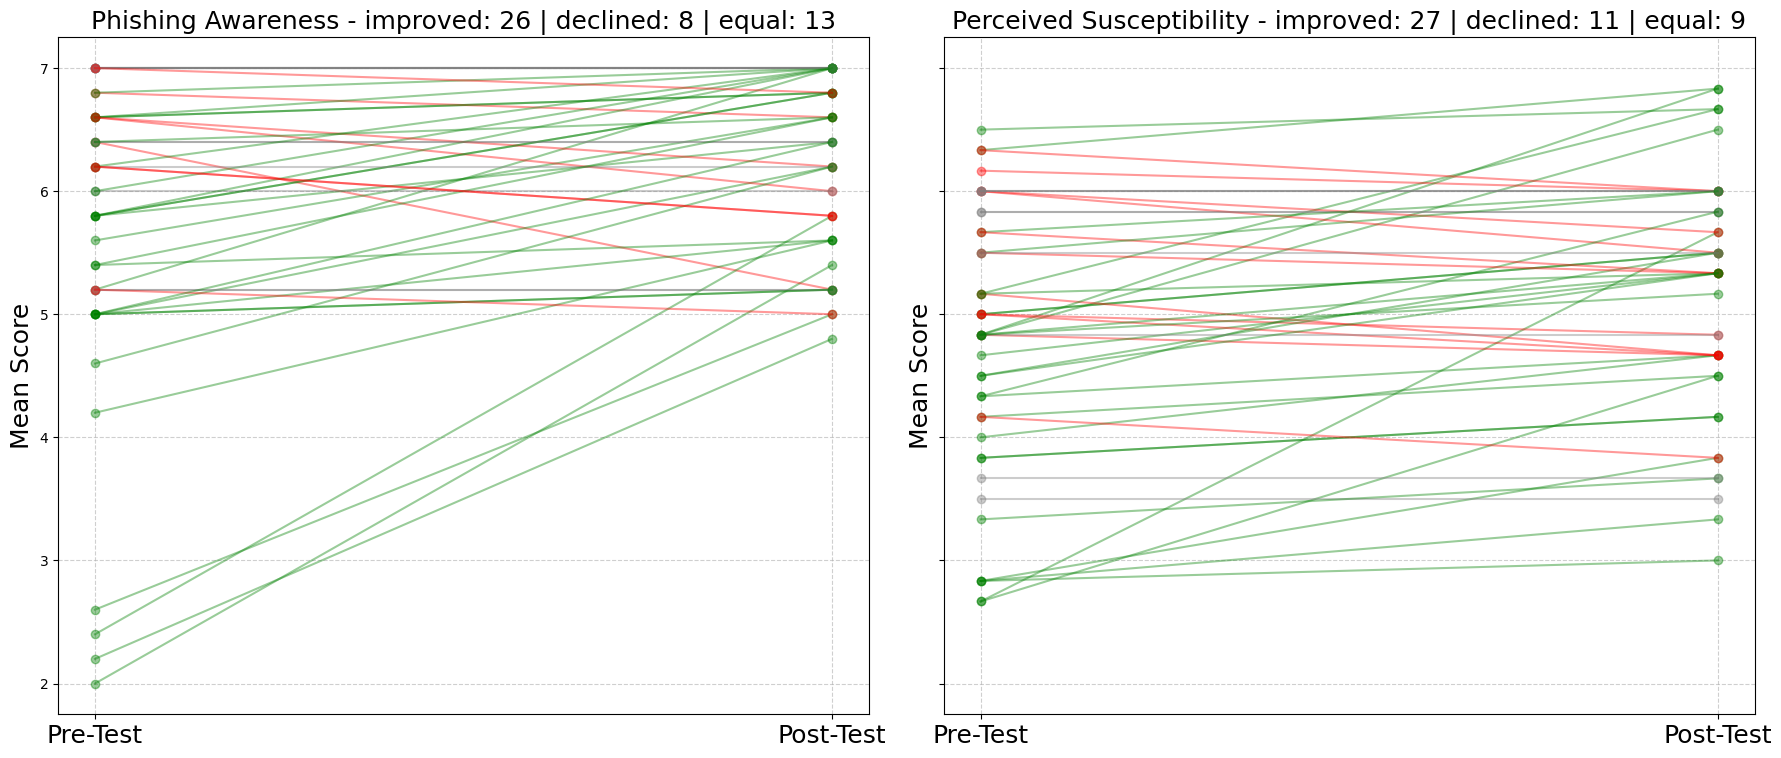

In [22]:
construct_pairs = [('PA01', 'PA02'), ('PS05', 'PS06')]
construct_titles = {
    'PA01': 'Phishing Awareness',
    'PS05': 'Perceived Susceptibility'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

for i, pair in enumerate(construct_pairs):
    pre_construct, post_construct = pair
    
    # Calculate mean scores for pre and post constructs
    pre_scores = data_finished_players_consistent[constructs[pre_construct]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
    post_scores = data_finished_players_consistent[constructs[post_construct]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
    
    # Combine into a temporary dataframe for plotting
    plot_df = pd.DataFrame({'Pre': pre_scores, 'Post': post_scores}).dropna()
    
    # Count improvements, declines, and no change
    improvements = (plot_df['Post'] > plot_df['Pre']).sum()
    declines = (plot_df['Post'] < plot_df['Pre']).sum()
    no_change = (plot_df['Post'] == plot_df['Pre']).sum()

    # Plot each participant's change
    for _, row in plot_df.iterrows():
        pre_val, post_val = row['Pre'], row['Post']
        color = 'green' if post_val > pre_val else 'red' if post_val < pre_val else 'gray'
        axes[i].plot([0, 1], [pre_val, post_val], marker='o', color=color, alpha=0.4)
        
    # Formatting the subplot
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Pre-Test', 'Post-Test'], fontsize=18)
    axes[i].set_title(f"{construct_titles.get(pre_construct, 'Construct')} - improved: {improvements} | declined: {declines} | equal: {no_change}", fontsize=18)
    axes[i].set_ylabel('Mean Score', fontsize=18)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Linear Regression: Narrative Enjoyment vs. Phishing Awareness

Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables. In this case, we want to see if there is a linear relationship between Narrative Enjoyment (independent variable) and Phishing Awareness (dependent variable).

- **Independent Variable (X):** Narrative Enjoyment (composite score from NE01, NE02, NE03).
- **Dependent Variable (Y):** Phishing Awareness (composite score from PA01, PA02).

We will look at the **R-squared** value, which represents the proportion of the variance in the dependent variable that is predictable from the independent variable, and the **p-value** to determine if the relationship is statistically significant.

--- Linear Regression Summary: Narrative Enjoyment vs. Phishing Awareness ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     7.844
Date:                Mon, 11 Aug 2025   Prob (F-statistic):            0.00749
Time:                        09:39:18   Log-Likelihood:                -45.990
No. Observations:                  47   AIC:                             95.98
Df Residuals:                      45   BIC:                             99.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

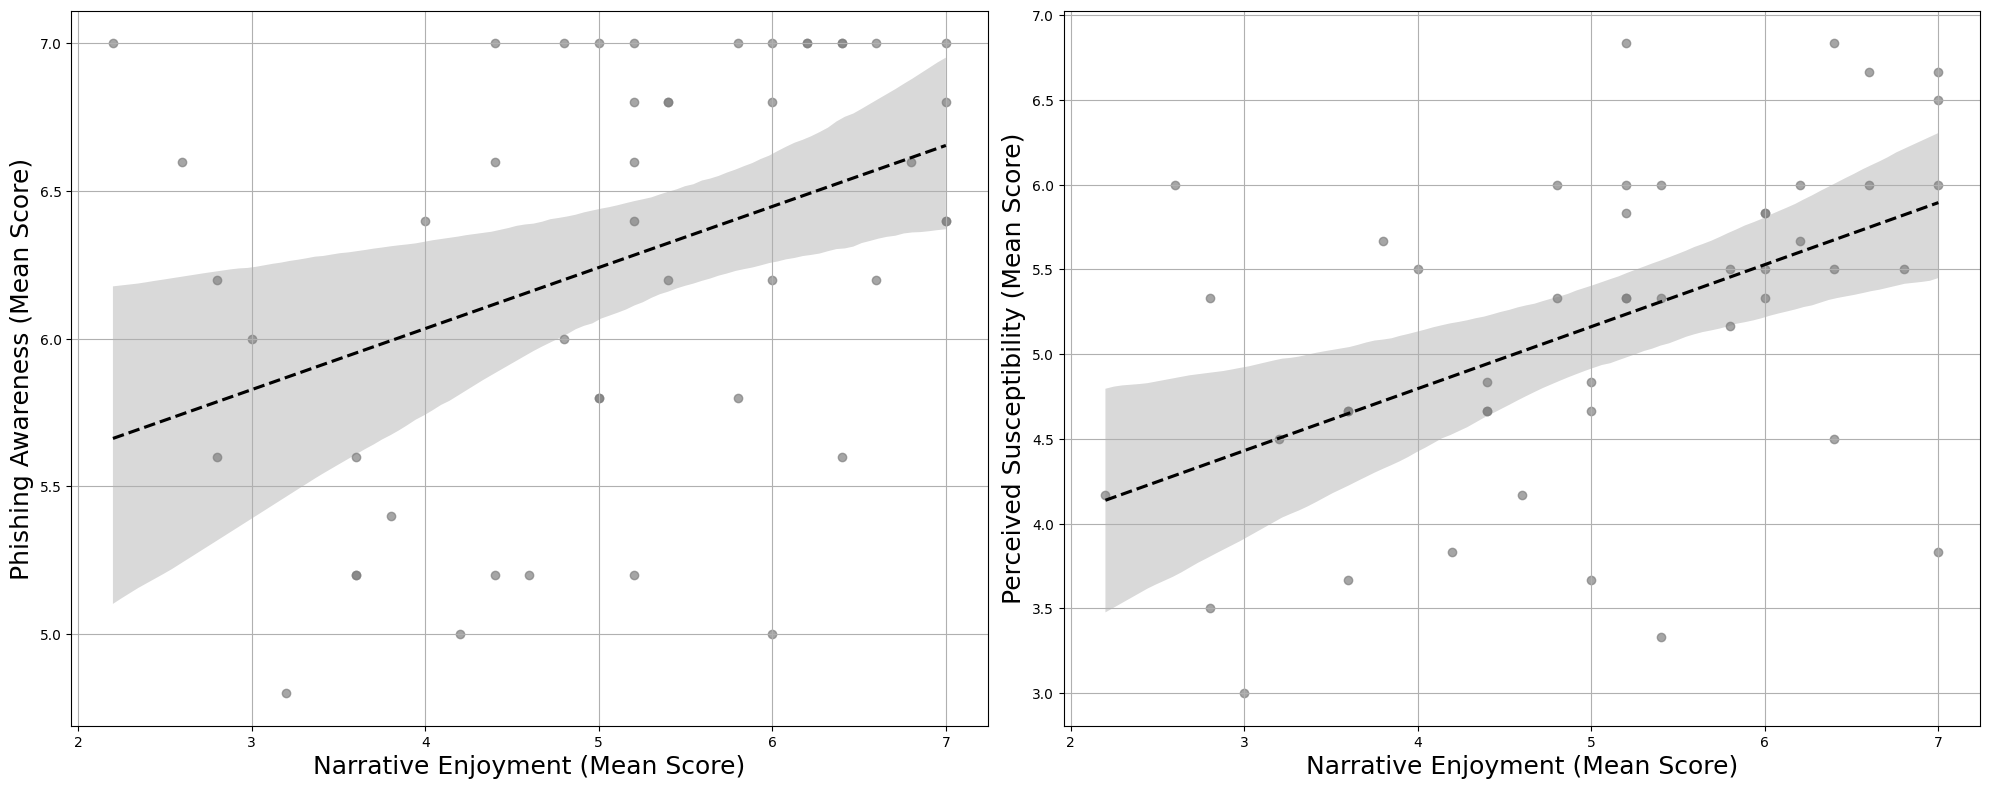

In [21]:
# --- Combined Linear Regression Plots ---

# 1. Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1: Narrative Enjoyment vs. Phishing Awareness ---

# Define items
narrative_enjoyment_items = constructs.get('NE01', []) + constructs.get('NE02', []) + constructs.get('NE03', [])
phishing_awareness_items = constructs.get('PA02', [])

# Calculate composite scores
X1 = data_finished_players_consistent[narrative_enjoyment_items].apply(pd.to_numeric, errors='coerce').mean(axis=1)
Y1 = data_finished_players_consistent[phishing_awareness_items].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Perform regression
X1_const = sm.add_constant(X1)
model1 = sm.OLS(Y1, X1_const).fit()
print("--- Linear Regression Summary: Narrative Enjoyment vs. Phishing Awareness ---")
print(model1.summary())
print("\\n" + "="*80 + "\\n")

# Plot on the first subplot
sns.regplot(x=X1, y=Y1, scatter=False, color='black', line_kws={'linestyle':'--'}, ax=ax1)
ax1.scatter(X1, Y1, color='gray', alpha=0.7)
ax1.set_xlabel('Narrative Enjoyment (Mean Score)', fontsize=18)
ax1.set_ylabel('Phishing Awareness (Mean Score)', fontsize=18)
ax1.grid(True)

# --- Plot 2: Narrative Enjoyment vs. Perceived Susceptibility ---

# Define items
perceived_susceptibility_items = constructs.get('PS06', [])

# Calculate composite scores (X is the same as before)
X2 = X1
Y2 = data_finished_players_consistent[perceived_susceptibility_items].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Perform regression
X2_const = sm.add_constant(X2)
model2 = sm.OLS(Y2, X2_const).fit()
print("--- Linear Regression Summary: Narrative Enjoyment vs. Perceived Susceptibility ---")
print(model2.summary())

# Plot on the second subplot
sns.regplot(x=X2, y=Y2, scatter=False, color='black', line_kws={'linestyle':'--'}, ax=ax2)
ax2.scatter(X2, Y2, color='gray', alpha=0.7)
ax2.set_xlabel('Narrative Enjoyment (Mean Score)', fontsize=18)
ax2.set_ylabel('Perceived Susceptibility (Mean Score)', fontsize=18)
ax2.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Analysis of Storyline Importance

Calculate the mean score ofs for storyline importance

In [19]:
storyline_importance_items = constructs.get('SI', [])

if not storyline_importance_items:
    print("No items found for the Storyline Importance construct.")
else:
    storyline_importance_means = data_finished_players_consistent[storyline_importance_items].apply(pd.to_numeric, errors='coerce').mean()

    print("--- Mean Scores for Storyline Importance ---")
    for item, mean_score in storyline_importance_means.items():
        print(f"{item}: {mean_score:.2f}")

--- Mean Scores for Storyline Importance ---
"SI02_01": 5.34
"SI02_02": 5.26
"SI02_03": 4.21
"SI02_04": 3.72
"SI02_05": 4.43
"SI02_06": 6.02
